In [1]:
import escher
from mewpy.simulation import get_simulator
from cobra.io import read_sbml_model


model = read_sbml_model("iML1515.xml")
simul = get_simulator(model)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-12-11


In [2]:
result = simul.simulate(method="pFBA")

O fluxo de da estirpe wild-type dá 0, ou seja, em situações normais, não produz lactato.

In [3]:
simul.summary()

Metabolites: 1877
Reactions: 2712
Genes: 1516


In [4]:
print(result.find("lac"))
print()
print(result.find("glc"))
print()
print(result.find("BIO"))
print()
print(result.find("o2"))

   Reaction ID  Flux rate
0  EX_lac__L_e        0.0
1  EX_lac__D_e        0.0

     Reaction ID  Flux rate
0      EX_glcn_e        0.0
1    EX_glc__D_e      -10.0
2     EX_glcur_e        0.0
3   EX_2ddglcn_e        0.0
4      EX_glcr_e        0.0
5   EX_glcur1p_e        0.0
6  EX_udpglcur_e        0.0
7    EX_5dglcn_e        0.0
8     EX_2dglc_e        0.0
9  EX_metglcur_e        0.0

                      Reaction ID  Flux rate
0  BIOMASS_Ec_iML1515_core_75p37M   0.876997
1    BIOMASS_Ec_iML1515_WT_75p37M   0.000000

  Reaction ID  Flux rate
0    EX_co2_e  24.003293
1   EX_h2o2_e   0.000000
2    EX_no2_e   0.000000
3    EX_so2_e   0.000000
4     EX_o2_e -22.131763
5    EX_o2s_e   0.000000


O lactato tem 2 códigos:
- **lac__D_e** (D-lactato)
- **lac__L_e** (L-lactato)<br>

Indica que o fluxo de ambos os compostos na estirpe *wt* é 0.<br>
Ficamos a saber também os códigos do fluxo de **glucose**, de **biomassa** e de **oxigénio**.<br><br>


# 1/2) Produção *wt* de Lactato e valores máximos e mínimos


Podemos agora aplicar as restrições à simulação:

In [12]:
const = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,10000)}

result = simul.simulate(method="pFBA", constraints = const)

In [16]:
const = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,10000)}

print(result.find("EX_lac__L_e"))
print(simul.FVA(reactions=["EX_lac__L_e"], constraints = const))
print()
print(result.find("EX_lac__D_e"))
print(simul.FVA(reactions=["EX_lac__D_e"], constraints = const))
print()
print(result.find("BIOMASS_Ec_iML1515_core_75p37M")) #Para comparar com o fluxo de biomassa após as alterações

   Reaction ID  Flux rate
0  EX_lac__L_e        0.0
{'EX_lac__L_e': [0.0, 1.114181818181784]}

   Reaction ID  Flux rate
0  EX_lac__D_e        0.0
{'EX_lac__D_e': [0.0, 12.255999999999567]}

                      Reaction ID  Flux rate
0  BIOMASS_Ec_iML1515_core_75p37M   0.266098


Aqui vemos que o valor máximo do fluxo de *EX_lac__L_e* é **1.11** e o de *EX_lac__D_e* é **12.26** 

# 3a) Melhorar fluxo de Lactato com *knockout* de um gene

Vamos agora ver se há melhorias no fluxo destas 2 reações quando se faz um knockout de um gene de cada vez.<br>
Definir: "**c = problem.solution_to_constraints({** gene **:0})**" )

In [16]:
from mewpy.problems import GKOProblem
problem = GKOProblem(model, [])

best_val_l = []
best_val_d = []

for g in simul.genes:
    c = problem.solution_to_constraints({g:0, **const})
    result = simul.simulate(method="pFBA", constraints=c)
    if result.fluxes["EX_lac__L_e"] != 0:
        best_val_l.append((g, result.fluxes["EX_lac__L_e"]))
    if result.fluxes["EX_lac__D_e"] != 0:
        best_val_d.append((g, result.fluxes["EX_lac__D_e"]))

In [17]:
print(best_val_l)
print(best_val_d)

[]
[('s0001', 6.86)]


Estes resultados permitem prever que:
- para o EX_lac__L_e, não há melhorias de fluxo com a deleção de apenas um gene<br>
- para o EX_lac__D_e, o fluxo melhora de 0 para **6.86** com a deleção do gene de identificador "s0001"<br>

Vamos agora ver como é que a deleção do gene afetou a produção de biomassa

In [29]:
from mewpy.problems import GKOProblem

problem = GKOProblem(model, [])
c = problem.solution_to_constraints({"s0001":0})
result = simul.simulate(method="pFBA", constraints = c)
result.fluxes["BIOMASS_Ec_iML1515_core_75p37M"]

0.0

Este resultado mostra-nos que, enquanto que a deleção do gene tem o potencial de melhorar a produção de lactose, é um gene essencial para o crescimento celular. Desta forma, a knockout deste gene não seria uma boa solução.

# 3b) Procura de estratégias para melhorar fluxo de Lactato

De seguida, vamos correr as simulações de otimização, usando o algoritmo EA, para cada composto (D-lactato e L-lactato) e usando as estratégias de *knockout* (**RKO**) e sub/sob-expressão (**ROU**):

### L-lactato - ROU

Building modification target list.
Running NSGAII


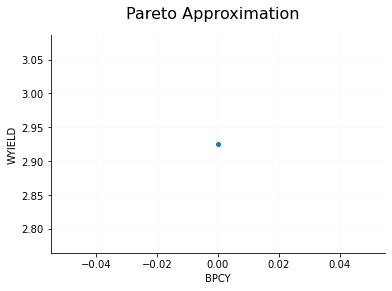

Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  2.925145  0.003343  0.249959  0.724617|
    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  2.925145  0.003343  0.554515  1.011484|
    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  2.925146  1.672944  1.322213  1.170172|
    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  1.672946  2.925150  2.507745  2.601484  0.270406|
    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  2.507745  2.925150  2.925145  2.858293  0.152993|
    600|  0.000000  0.000000  0.000000  0.000000  0.000000|  2.925145  2.925151  2.925145  2.925146  0.000001|
    700|  0.000000  0.000000  0.000000  0.000000  0.000000|  2.925145  2.925151  2.925145  2.925146  0.000002|
    800|  0.000000  0.000000  0.000000  0.000000  0.000000|  2.925145  2.925151  2.925146  2.925146  0.000002|
 

C:\Users\rober\anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [30]:
# environmental conditions
envcond = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,100000.0)}

# Define the target
PRODUCT_ID = 'EX_lac__L_e'
BIOMASS_ID = 'BIOMASS_Ec_iML1515_core_75p37M'
UPTAKE_ID = 'EX_glc__D_e'

# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, UPTAKE_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

#from mewpy.problems import RKOProblem
#problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond)

from mewpy.problems import ROUProblem
problem = ROUProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size = 5)

from mewpy.optimization import EA
ea = EA(problem, max_generations= 10, visualizer=True)
final_pop = ea.run()

In [31]:
final_pop

[[0.0, 2.9251454914696366];{'U23GAAT': 0.125},
 [0.0, 0.0];{'OPMEACPS': 8},
 [0.0, 2.9251454914696553];{'DGUNC': 0, 'ARGSL': 0.125, 'PGMT': 0.125, 'KDOPS': 0.25},
 [0.0, 2.9251454914696553];{'U23GAAT': 0.125, 'ARGSL': 0.125, 'PGMT': 0.125, 'KDOPS': 0.25},
 [0.0, 2.9251454914696553];{'U23GAAT': 0.125, 'DGUNC': 0, 'PGMT': 0.125, 'KDOPS': 0.25},
 [0.0, 2.9251454914696553];{'U23GAAT': 0.125, 'DGUNC': 0, 'ARGSL': 0.125, 'PGMT': 0.125},
 [0.0, 2.9251454914696553];{'U23GAAT': 0.125, 'DGUNC': 0, 'ARGSL': 0.125, 'KDOPS': 0.25},
 [0.0, 2.925145491469653];{'ARGSL': 0.125},
 [0.0, 2.9251454914696042];{'DGUNC': 0, 'SARCOX': 2, 'ARGSL': 0.125, 'DHNPA2r': 0.5},
 [0.0, 2.9251454914696042];{'U23GAAT': 0.125, 'SARCOX': 2, 'ARGSL': 0.125, 'DHNPA2r': 0.5},
 [0.0, 2.9251454914696042];{'U23GAAT': 0.125, 'DGUNC': 0, 'SARCOX': 2, 'DHNPA2r': 0.5},
 [0.0, 2.9251454914696042];{'U23GAAT': 0.125, 'DGUNC': 0, 'SARCOX': 2, 'ARGSL': 0.125},
 [0.0, 2.9251454914696042];{'U23GAAT': 0.125, 'DGUNC': 0, 'ARGSL': 0.125, 'DH

### L-lactato - RKO

Building modification target list.
Computing essential reactions


100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [04:20<00:00, 10.42it/s]


Running NSGAII


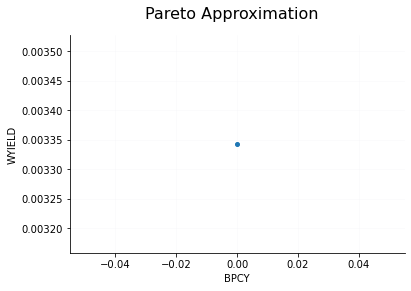

Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.000000  0.003343  0.003343  0.003299  0.000339|
    200|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    300|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    400|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    500|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    600|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    700|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
    800|  0.000000  0.000000  0.000000  0.000000  0.000000|  0.003343  0.003343  0.003343  0.003343  0.000000|
 

In [32]:
# environmental conditions
envcond = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,100000.0)}

# Define the target
PRODUCT_ID = 'EX_lac__L_e'
BIOMASS_ID = 'BIOMASS_Ec_iML1515_core_75p37M'
UPTAKE_ID = 'EX_glc__D_e'

# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, UPTAKE_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

#from mewpy.problems import RKOProblem
#problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond)

from mewpy.problems import RKOProblem
problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size = 5)

from mewpy.optimization import EA
ea = EA(problem, max_generations= 10, visualizer=True)
final_pop1 = ea.run()

In [33]:
final_pop1

[[0.0, 0.003342545454608725];{}]

### D-lactato - ROU

Building modification target list.
Running NSGAII


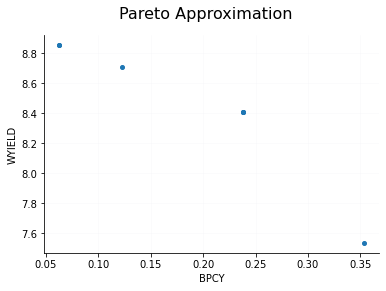

Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.353217  0.000000  0.016041  0.055804|  0.000000  8.852624  0.036768  0.704723  2.297196|
    200|  0.000000  0.353217  0.000000  0.028922  0.072240|  0.000000  8.852624  0.036768  1.300447  3.028842|
    300|  0.000000  0.353217  0.016332  0.065408  0.095865|  0.000000  8.852625  0.036811  3.217033  4.107857|
    400|  0.000000  0.353217  0.122535  0.148400  0.116805|  0.000000  8.852625  8.556560  7.335623  2.802958|
    500|  0.062891  0.353217  0.122575  0.176850  0.109802|  7.534562  8.852869  8.705248  8.449404  0.485533|
    600|  0.062891  0.353217  0.122857  0.181994  0.109063|  7.534562  8.852869  8.705248  8.436937  0.480260|
    700|  0.062891  0.353217  0.238508  0.202155  0.109936|  7.534562  8.852869  8.410497  8.363155  0.494312|
    800|  0.062891  0.353217  0.238508  0.209483  0.119239|  7.534562  8.852869  8.410497  8.280302  0.559772|
 

In [49]:
# environmental conditions
envcond = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,100000.0)}

# Define the target
PRODUCT_ID = 'EX_lac__D_e'
BIOMASS_ID = 'BIOMASS_Ec_iML1515_core_75p37M'
UPTAKE_ID = 'EX_glc__D_e'

# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, UPTAKE_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

#from mewpy.problems import RKOProblem
#problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond)

from mewpy.problems import ROUProblem
problem = ROUProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size = 5)

from mewpy.optimization import EA
ea = EA(problem, max_generations= 30, visualizer=True)
final_pop2 = ea.run()

In [51]:
final_pop2

[[0.06227710776986589, 8.854635960505819];{'ACOAD5f': 0, 'ACOAD1fr': 0.03125, 'A5PISO': 0.125, 'MTHFC': 0.03125},
 [0.12570695307510207, 8.705248203073612];{'FACOAE160': 32, 'A5PISO': 0.25, 'ACOAD1fr': 0.03125, 'MTHFC': 0.03125},
 [0.2453950629217673, 8.410496406147203];{'FACOAE160': 32, 'TMPK': 0.5, 'ACOAD1fr': 0.03125, 'MTHFC': 0.03125},
 [0.12318566651331354, 8.705248203073616];{'A5PISO': 0.25, 'ACOAD1fr': 0.03125, 'MTHFC': 0.03125},
 [0.24077723863697004, 8.410496406147255];{'TMPK': 0.5, 'ACOAD1fr': 0.03125, 'MTHFC': 0.03125},
 [0.24315533956881252, 8.410496406147226];{'FACOAE160': 16, 'TMPK': 0.5, 'ACOAD5f': 0.03125, 'MTHFC': 0.03125},
 [0.06413317348194823, 8.852624327494032];{'FACOAE160': 32, 'IPMD': 0.125, 'ACOAD1fr': 0.0625},
 [0.06245775996121621, 8.854569089257225];{'IPMD': 0.125, 'MTHFC': 0},
 [0.0630036156697067, 8.852868948987712];{'FACOAE160': 0, 'ACOAD1fr': 0.03125, 'MTHFC': 0.03125, 'DTMPK': 0.125},
 [0.06299323551177322, 8.852868948987712];{'FACOAE160': 0, 'ACOAD5f': 

### D-lactato - RKO

Building modification target list.
Computing essential reactions


  5%|███▋                                                                           | 125/2712 [00:12<04:03, 10.61it/s]C:\Users\rober\anaconda3\lib\site-packages\cobra\util\solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
100%|██████████████████████████████████████████████████████████████████████████████| 2712/2712 [04:11<00:00, 10.80it/s]


Running NSGAII


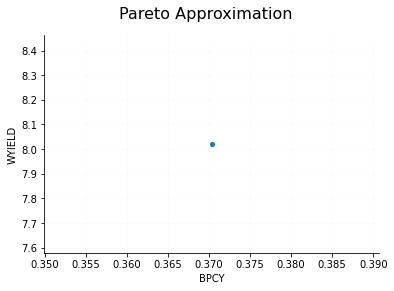

Eval(s)|     Worst      Best    Median   Average   Std Dev|     Worst      Best    Median   Average   Std Dev|
    100|  0.000000  0.370323  0.000000  0.007014  0.049180|  0.000000  8.020531  0.036768  0.186761  1.061459|
    200|  0.000000  0.370323  0.000000  0.014421  0.070729|  0.036768  8.020531  0.036768  0.347817  1.525519|
    300|  0.000000  0.370323  0.000000  0.043263  0.117304|  0.036768  8.020531  0.036768  0.969915  2.530040|
    400|  0.000000  0.370323  0.000000  0.136801  0.175063|  0.036768  26.544164  0.036768  3.172820  4.418026|
    500|  0.000000  0.370323  0.370323  0.338510  0.087107|  0.036768  26.544164  8.020531  8.453306  4.937012|
    600|  0.354431  0.370323  0.370323  0.370100  0.001590|  8.020531  26.544164  8.020531  10.798738  6.613198|
    700|  0.368581  0.370323  0.370323  0.370216  0.000201|  8.020531  26.559609  8.020531  15.059667  8.991317|
    800|  0.368581  0.370323  0.370320  0.370208  0.000202|  8.020531  26.559609  8.020541  15.615377  9.1

In [47]:
# environmental conditions
envcond = {'EX_glc__D_e'  : (-15.0, 100000.0),
           'EX_o2_e' : (0,100000.0)}

# Define the target
PRODUCT_ID = 'EX_lac__D_e'
BIOMASS_ID = 'BIOMASS_Ec_iML1515_core_75p37M'
UPTAKE_ID = 'EX_glc__D_e'

# Optimization objectives
from mewpy.optimization.evaluation import  BPCY, WYIELD
evaluator_1 = BPCY(BIOMASS_ID, PRODUCT_ID, UPTAKE_ID, method='pFBA')
evaluator_2 = WYIELD(BIOMASS_ID, PRODUCT_ID)

#from mewpy.problems import RKOProblem
#problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond)

from mewpy.problems import RKOProblem
problem = RKOProblem(model, fevaluation=[evaluator_1, evaluator_2], envcond=envcond, candidate_max_size = 5)

from mewpy.optimization import EA
ea = EA(problem, max_generations= 30, visualizer=True)
final_pop3 = ea.run()

In [48]:
final_pop3

[[0.3703226574862162, 8.020528973353564];{'ACALD': 0},
 [0.3683158614915255, 26.562341103516907];{'ACOAD6f': 0, 'ACKr': 0, 'ACALD': 0},
 [0.3700803194305872, 26.544171601337318];{'ACKr': 0, 'ACALD': 0},
 [0.3703178757177117, 8.020543619044009];{'I4FE4ST': 0, 'ADNK1': 0, 'ACALD': 0},
 [0.36858064634190096, 26.55961628111601];{'ACALD': 0, 'ACKr': 0, 'CYTK1': 0},
 [0.37007554480781973, 26.54422080612077];{'I4FE4ST': 0, 'ACALD': 0, 'PPM': 0, 'ACKr': 0},
 [0.3685018069867585, 26.560427659873916];{'DURIPP': 0, 'ACKr': 0, 'PPM': 0, 'CYTK1': 0, 'ACALD': 0},
 [0.3685050396606445, 26.560394391771972];{'DURIPP': 0, 'ACKr': 0, 'CYTK1': 0, 'ACALD': 0},
 [0.3685759095575169, 26.55966503153417];{'I4FE4ST': 0, 'PPM': 0, 'ACKr': 0, 'CYTK1': 0, 'ACALD': 0},
 [0.36850353742819714, 26.56040985156336];{'I4FE4ST': 0, 'DURIPP': 0, 'ACKr': 0, 'CYTK1': 0, 'ACALD': 0},
 [0.3703211403775507, 8.020533619989498];{'I4FE4ST': 0, 'ACALD': 0},
 [0.37031939280017184, 8.020538972502171];{'ACALD': 0, 'PPM': 0},
 [0.37007

Os resultdos mostram que apenas para as simulações feitas ao D-lactato é que foi possível melhorar o fluxo e ao mesmo tempo manter a produção de biomassa positiva. Desta forma, selecionou-se uma das soluções de entre as apresentadas que parece ser a mais razoável de se aplicar e que tem um valor elevado de fluxo de lactato e de biomassa associado:
- **[0.3700803194305872, 26.544171601337318] ; {'ACKr': 0, 'ACALD': 0}**

In [10]:
const = {"ACKr":(0,0), "ACALD":(0,0), 'EX_glc__D_e'  : (-15.0, 100000.0), 'EX_o2_e' : (0,10000)}
result = simul.simulate(method="pFBA", constraints = const)

print(result.find("EX_lac__D_e"))
print()
print(simul.FVA(reactions=["EX_lac__D_e"], constraints = const))
print()
print()
print(result.find("BIOMASS_Ec_iML1515_core_75p37M"))
print()
print(simul.FVA(reactions=["BIOMASS_Ec_iML1515_core_75p37M"], constraints = const))

   Reaction ID  Flux rate
0  EX_lac__D_e  26.668039

{'EX_lac__D_e': [11.570203860940747, 27.230339294122086]}


                      Reaction ID  Flux rate
0  BIOMASS_Ec_iML1515_core_75p37M   0.208159

{'BIOMASS_Ec_iML1515_core_75p37M': [0.18734351937956611, 0.20815946597729315]}


Conclui-se que, de acordo com a previsão do modelo, ao meter o valor do fluxo de ACKr e ACALD nulo, obtemos um fluxo de D-lactato de valor 26.67 e um fluxo de biomassa de valor 

### (Ver quais os fluxos de outros compostos que foram afetados)

In [27]:
const1 = {'EX_glc__D_e'  : (-15.0, 100000.0), 'EX_o2_e' : (0,10000)}
result1 = simul.simulate(method="pFBA", constraints = const1)

const2 = {"ACKr":(0,0), "ACALD":(0,0), 'EX_glc__D_e'  : (-15.0, 100000.0), 'EX_o2_e' : (0,10000)}
result2 = simul.simulate(method="pFBA", constraints = const2)

fluxes = []

for f in result1.fluxes:
    if (result1.fluxes[f] != 0) and (result2.fluxes[f] == 0):
        fluxes.append((f, round(result1.fluxes[f],3)))

for f in fluxes:
    print(f)

('ACALD', -12.881)
('PTAr', 12.87)
('ACKr', -12.87)
('ALCD2x', -12.881)
('NDPK2', 0.113)
('NDPK3', 0.048)
('NDPK4', 0.007)
('NDPK1', 0.21)
('GLUt2rpp', -0.001)
('GLUt4pp', 0.001)
('ETOHtex', -12.881)
('EX_etoh_e', 12.881)
('ETOHtrpp', -12.881)


(Agora retirando os fluxos negativos (ou seja, de consumo)):

In [28]:
fluxes = []

for f in result1.fluxes:
    if (result1.fluxes[f] > 0) and (result2.fluxes[f] == 0):
        fluxes.append((f, round(result1.fluxes[f],3)))

for f in fluxes:
    print(f)

('PTAr', 12.87)
('NDPK2', 0.113)
('NDPK3', 0.048)
('NDPK4', 0.007)
('NDPK1', 0.21)
('GLUt4pp', 0.001)
('EX_etoh_e', 12.881)
